## This notebook's owner is Mohamed Amine Chafik (github account : https://github.com/MedAmine-1 and email : mohamedamine.chafik@emines.um6p.ma) and has pursued this work in light of his Technical Test Interview process at FinaMaze.

In [22]:
# Importing the needed libraries
import json
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
import random

In [23]:
# Reading the json file as a dictionary
import json

with open("/Users/mohamedaminechafik/Desktop/Finamaze project/data_market.json") as jsonFile:
    jsonObject = json.load(jsonFile)
    jsonFile.close()

In [24]:
list(jsonObject.keys())

['NDX', 'GOOG', 'AMZN', 'TSLA', 'AAPL', 'UBER', 'NFLX']

# STEP I : DATA PROCESSING

In [25]:
def get_stock_price( jsonObject= jsonObject,
                    stocks : list = None, 
                    start : str= None, 
                    end : str = None ) -> dict :

    """ This function aims to perform stock prices extraction from a json file
    #   Parameters:

    jsonObject (jsonObject):The jsonObject which is data in json format.

    stocks (list):The list that contains names of stocks.

    start (str):The string which is the start of the extraction period.

    end (str):The string which is the end of the extraction period.

    #   Returns:

    A dictionary of dataframes. The number of dataframes is the number of stocks. """
                    
    if stocks == None :
        stocks = list(jsonObject.keys())
        
    dic = dict()
    
    for stock in stocks:
        data_stock = pd.DataFrame(data = jsonObject[stock])
        data_stock["Date"] = pd.to_datetime(data_stock ["Date"])
        data_stock  = data_stock.set_index("Date")
        data_stock = data_stock.sort_values(by=["Date"])["Close"]
        data_stock = data_stock.loc[start:end]
        dic[stock] = data_stock

    return dic
    
    

    The chosen format we will us is the pandas DataFrame/Series as the Pandas library is made for data manipulation and rich with tools to quickly compute and perform analysis.

# STEP II : DATA WRANGLING AND VISUALIZATION

    Let's first analyse how many data points are missing in order to assess the best method to impute it.
    For this end, we will compare the time series we extract with our get_stock_price function, with a date time series that eventually only contains business days. We choose not to drop holiday days as we don't know the exchange and the country where we will trade.

    The logic of missing data only holds after companies getting public through IPOs so no stock price exists before this date.   

    What we will do is create a business days only time series and join with our stock in order to dertermine what dates are missing. (they will receive a nan after this join operation). As our data has a clear trend (uprising) and slight seasonality the best way to address missing data is with filling the missing values with linear interpolation.

In [26]:
def ampute_missing_data(
                    stocks : list = None, 
                    start : str= None, 
                    end : str = None ):
    
    fixed = dict()

    for stock in ['NDX', 'GOOG', 'AMZN', 'TSLA', 'AAPL', 'UBER', 'NFLX'] :
    
        val = pd.DataFrame( data = { 'Date': list(get_stock_price(stocks=[stock], start = start, end = end)[stock].index) ,
                                'Stock': list( get_stock_price(stocks=[stock], start = start, end = end)[stock])} )

        dates = pd.DataFrame(data = {"Date" : pd.date_range(start = start, end = end, freq='B')} )

        e = dates.merge(val, how='left', on='Date')
        e["Stock"] = e["Stock"].interpolate()
        e.index = e['Date']
        fixed[stock] =  e.drop(columns = ["Date"])



    return fixed
    


In [27]:
ampute_missing_data(start= "2019-05-07",end= "2021-10-01")["UBER"]

,Stock
Date,
2019-05-07,NaN
2019-05-08,NaN
2019-05-09,NaN
2019-05-10,41.570000
2019-05-13,37.099998
...,...
2021-09-27,47.250000
2021-09-28,45.980000
2021-09-29,44.520000


    Stock prices is plot in the next cell


In [28]:

for i in [ 'GOOG',  'TSLA', 'AAPL'] :
    plt.pyplot.plot(get_stock_price(stocks=[i])[i] ,label = i)
    plt.pyplot.xlabel("Date")
    plt.pyplot.ylabel("Stock Price")
    plt.pyplot.legend()

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

# STEP III : GET TO KNOW DATA

    Let's imagine that an investor invests $100 in each of these stocks ( using the stocks of previous selection) . What would be the weekly value of each of these stocks investment ? Plot them on the same graph.

In [ ]:
def get_investment_weekly_value(stocks = [ 'GOOG',  'TSLA', 'AAPL'] ,
                            investment = 100,
                            start= "2021-01-01",
                            end = "2021-12-31"):
    
    dic = get_stock_price( stocks = stocks ,
                            start= start,
                            end = end )

    for i in stocks :
        dic_resampled = dic.copy()

        dic_resampled = dic_resampled[i].resample("W-MON").last()
       
        weekly_value = investment + ( get_stock_price(stocks =[i] , start = start , end = end)[i].resample("W-MON").last() 
                                        / (get_stock_price(stocks = [i], start = "2017-01-01", end = end  )[i]["2017-01-03"] )
                                         - 1 )* investment
    
        plt.plot(weekly_value,label = i)
        plt.xlabel("Week")
        plt.ylabel("Weekly Return")
        plt.legend()
        plt.xticks(rotation=45)
        plt.axhline(y = 100, color = 'r', linestyle = '-')
        
    plt.title("Weekly Returns of Stocks")




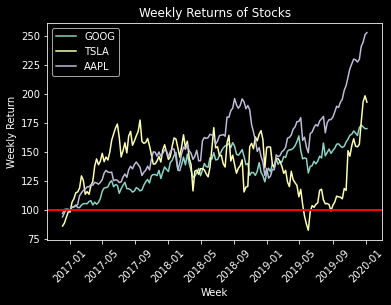

In [ ]:
get_investment_weekly_value(start = "2016-12-01", end = "2019-12-31")

    Compute their daily returns and compare their distributions can we infer that they are normal

In [ ]:
def get_daily_returns(stocks = [ 'GOOG',  'TSLA', 'AAPL'] ,
                           
                            start= "2021-01-01",
                            end = "2021-12-31"):
    
    dic = get_stock_price(stocks = stocks ,
                            start= start,
                            end = end )
    weekly_return = dict()

    for stock in stocks:
        data_stock = dic[stock]
        weekly_return[stock] = (data_stock/data_stock.shift(1) - 1)

    
    return weekly_return

<AxesSubplot:>

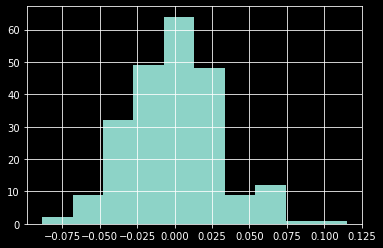

In [ ]:
get_daily_returns(stocks = ['UBER'])["UBER"].hist()

    Let us check if the daily returns distribution is normal via the normal distribution test

In [ ]:
stocks = get_daily_returns(stocks = [ 'GOOG',  'TSLA', 'AAPL'])

for stock in ['GOOG',  'TSLA', 'AAPL'] :
    k2, p = stats.normaltest(stocks[stock][1:])
    alpha = 1e-3
    # print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The stock",stock,"distribution comes from a normal distribution can be rejected.")
    else:
        print("The stock",stock,"distribution comes from a normal distribution cannot be rejected.")


The stock GOOG distribution comes from a normal distribution can be rejected.
The stock TSLA distribution comes from a normal distribution cannot be rejected.
The stock AAPL distribution comes from a normal distribution cannot be rejected.


    Let's Compute the following metrics for every month of 2021 and annualize these metrics ( Returns, volatility, sharp ratio) \
    We will consider a risk free rate of 1%

In [ ]:
def get_returns(stocks = ['GOOG',  'TSLA', 'AAPL'], 
                            start= "2021-01-01",
                            end = "2021-12-31",
                            annualize = False):

    returns = dict()
    for stock in stocks :
        daily_returns = get_daily_returns(stocks = [stock], start = start , end = end)[stock][1:]
        returns[stock] = daily_returns.add(1).resample("M").prod() - 1

        if annualize :
            returns[stock] = pow(returns[stock].add(1).prod(),12/ returns[stock].shape[0]) - 1

    return returns
        
    

In [ ]:
def get_volatility(stocks = ['GOOG',  'TSLA', 'AAPL'], 
                            start= "2021-01-01",
                            end = "2021-12-31",
                            annualize = False):

    volatility = dict()
    for stock in stocks :
        monthly_volatility  = get_daily_returns(stocks = [stock], start = start , end = end)[stock][1:].resample("M").apply(np.std)
        volatility[stock] = monthly_volatility

        if annualize :
            volatility[stock] = volatility[stock].mean() * np.sqrt(12)

    return volatility

In [ ]:
def get_sharpratio(stocks = ['GOOG',  'TSLA', 'AAPL'], 
                            start= "2021-01-01",
                            end = "2021-12-31", 
                            risk_free_rate = 0.01,
                            annualize = False) :

    sharpratio = dict()
    for stock in stocks :
        monthly_sharpratio  = (get_returns(stocks = [stock], start = start , end = end)[stock] - risk_free_rate) / get_volatility(stocks = [stock], start = start , end = end)[stock]
        sharpratio[stock] = monthly_sharpratio

        if annualize :
            sharpratio[stock] = monthly_sharpratio.mean() * np.sqrt(12)

    return sharpratio

<AxesSubplot:xlabel='Date'>

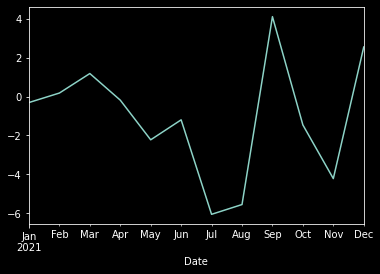

In [ ]:
get_sharpratio(stocks=['NDX','TSLA','AAPL', 'UBER'], annualize=False)["UBER"].plot()

#  STEP IV : INVESTOR STRATEGIES SIMULATIONS

    Let's try finding the way to determine the portion of each of these three stocks.

# STEP V : DEALING WITH OPPORTUNITIES

    Let's Help Omar backtest his strategy to confirm his resuls

    By doing some research, a moving average crossover strategy is based on the following :

    When the short term moving average crosses above the long term moving average, this indicates a buy signal.
    Contrary, when the short term moving average crosses below the long term moving average, it may be a good moment to sell.


In [ ]:
AAPL_2021 = pd.DataFrame(data = get_stock_price(stocks = ["AAPL"], start="2021-01-01" , end = "2021-12-31")["AAPL"])
AAPL_2021["10_SMA"] = AAPL_2021["Close"].rolling(window = 10, min_periods = 1).mean()
AAPL_2021["30_SMA"] = AAPL_2021["Close"].rolling(window = 30, min_periods = 1).mean()

# Add signal variable
AAPL_2021['Signal'] = 0.0
AAPL_2021['Signal'] = np.where(AAPL_2021['10_SMA'] > AAPL_2021['30_SMA'], 1.0, 0.0)

# Add position variable
AAPL_2021["Position"] = AAPL_2021["Signal"].diff()

AAPL_2021

,Close,10_SMA,30_SMA,Signal,Position
Date,,,,,
2021-01-04,129.410004,129.410004,129.410004,0.0,NaN
2021-01-05,131.009995,130.209999,130.209999,0.0,0.0
2021-01-06,126.599998,129.006666,129.006666,0.0,0.0
2021-01-08,132.050003,129.767500,129.767500,0.0,0.0
2021-01-11,128.979996,129.609999,129.609999,0.0,0.0
...,...,...,...,...,...
2021-12-22,175.639999,174.910001,162.943668,1.0,0.0
2021-12-23,176.279999,175.030000,163.770001,1.0,0.0
2021-12-28,179.289993,175.503000,164.714334,1.0,0.0


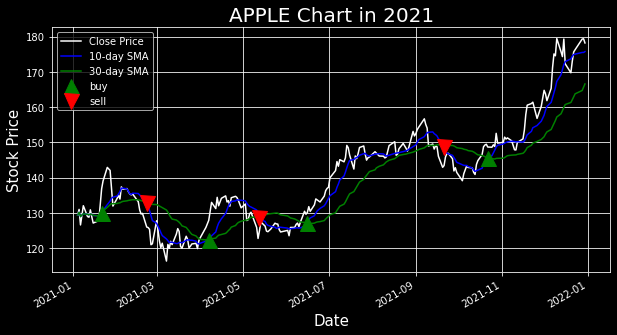

In [ ]:
plt.figure(figsize = (10,5))

# plot close price, short-term and long-term moving averages 
AAPL_2021["Close"].plot(color = "w", label= "Close Price") 
AAPL_2021["10_SMA"].plot(color = "b",label = "10-day SMA") 
AAPL_2021["30_SMA"].plot(color = "g", label = "30-day SMA")

# plot ‘buy’ signals
plt.plot(AAPL_2021[AAPL_2021["Position"] == 1].index, 
         AAPL_2021["10_SMA"][AAPL_2021["Position"] == 1], 
         "^", markersize = 15, color = "g", label = 'buy')

# plot ‘sell’ signals
plt.plot(AAPL_2021[AAPL_2021["Position"] == -1].index, 
         AAPL_2021["10_SMA"][AAPL_2021["Position"] == -1], 
         "v", markersize = 15, color = "r", label = 'sell')
         
plt.ylabel('Stock Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title('APPLE Chart in 2021', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

    Lets backtest the proposed method

In [ ]:
buy_prices = np.array(AAPL_2021["Close"][AAPL_2021["Position"] == 1][:-1])
sell_prices = np.array(AAPL_2021["Close"][AAPL_2021["Position"] == -1])

In [ ]:
return_strategy = (sell_prices / buy_prices).prod() - 1
print("This strategy's return is : ", round(return_strategy*100,3),"%")

This strategy's return is :  -0.873 %


    This backtest implies that our strategy doesn't even give us a positive return in 2021, we underperformed the 75% benchmark. Nevertheless, backtesting on another timeframe could give us different results.

# STEP VI : Numerical Techniques and Algorithms

    Let's find an efficient and elegant way to determine a and b. As a and b are consecutive, our function should only find the first (smallest) one, the other one comes next.

In [ ]:
def get_missing_numbers(arr, n):
    
    # Create a boolean vector of size n+1 and
    # mark all present elements of arr[] in it.
    mark = [False for i in range(n+1)]
    for i in range(0,n-2,1):
        mark[arr[i]] = True

    # Print two unmarked elements
    print("Two Missing Numbers are")
    for i in range(1,n+1,1):
        if (mark[i] == False):
            print(i,end = " ")

    print("\n")


In [ ]:
arr = [1, 3, 5, 6]

# Range of numbers is 2 plus size of array
n = 2 + len(arr)

get_missing_numbers(arr, n)

Two Missing Numbers are
2 4 



    Taking seat probability : 

    Calculating the probability of the last passenger seating in the 56th (his, naturally, accurate seat) is equivalent to calculating 
    the probability of him seating in the wrong seat.

    Let's start by calculating the probabilty of a passenger k takes a wrong seat
    Which means that someone with a smaller number (than k) already took a wrong seats too.
    
    So there's a m (random) of events j : j_1 to j_m (between 1 and k strictly) with same situation.

    And thee probability of the sequence of events will nothing but the product of the probability of their happening 
    We have the probabilty of events j_i is 1 / (n + 1 - j_i)

    Therefore the probability of a passenger k get a wrong seat will the sum of the value of j that are in  [2, k-1]. 
    And  we get :  the probability of the k passenger is  1 / (n + 2 - k)

In [ ]:
def probility_k_passenger (n, k):
    return 1 / (n + 2 - k)

# For our case the n = 56 and k = 56 
probility_k_passenger(56, 56)

# Simulation :

seats = [ i for i in range (1, 57)]

j = random.randint (2, 56)

sampled_list = random.sample(seats, j)

def probaility_event_j (n, j):
    return 1 / (n + 1 - j)

def probility_k_passenger_2 (n) :
    prod = 1
    for i in range(2, n) :
        prod = prod * (1 + probaility_event_j(n, i))
    return prod / n

In [ ]:
probility_k_passenger_2(2)

0.5